In [1]:
import numpy as np
import pandas as pd
import pickle
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, GRU, Embedding, CuDNNGRU ,Conv2D, Flatten , CuDNNLSTM
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
EMBEDDING_DIM = 100      # embedding dimensions for word vectors (word2vec/GloVe)
GLOVE_DIR = "glove/glove.6B."+str(EMBEDDING_DIM)+"d.txt"

In [2]:
dataset = pd.read_csv('data.csv')
df=pd.DataFrame(data,columns=['text','label'])



target = df['label'].tolist()
data = df['text'].tolist()


In [3]:
stopwords = stopwords.words('english')

for i in range(0,len(data)):
    words=word_tokenize(data[i])
    filtered_words=""
    for word in words:
        if word not in stopwords:
            filtered_words=filtered_words+ ' ' +word
    data[i]=filtered_words


In [4]:
cutoff = int(len(data) * 0.80)
x_train, x_test = data[:cutoff], data[cutoff:]
y_train, y_test = target[:cutoff], target[cutoff:]
x_train[1]

' @ azzamalirhabi @ jihadia8 video peshmerga decimating isis far interesting . https : //t.co/d36g1z12np'

In [5]:
num_words = 10000
tokenizer = Tokenizer(num_words=num_words,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{"}~\t\n',
               lower=True,
               char_level=False,
               split=' ')

tokenizer.fit_on_texts(data)
word_index = tokenizer.word_index
x_train_tokens = tokenizer.texts_to_sequences(x_train)
x_test_tokens = tokenizer.texts_to_sequences(x_test)

In [6]:
num_tokens = [len(tokens) for tokens in x_train_tokens + x_test_tokens]
num_tokens = np.array(num_tokens)
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)
max_tokens
np.sum(num_tokens < max_tokens) / len(num_tokens)

0.976742418484457

In [7]:
x_train_pad = pad_sequences(x_train_tokens, maxlen=max_tokens)
x_test_pad = pad_sequences(x_test_tokens, maxlen=max_tokens)

In [8]:
idx = tokenizer.word_index
inverse_map = dict(zip(idx.values(), idx.keys()))
def tokens_to_string(tokens):
    words = [inverse_map[token] for token in tokens if token!=0]
    text = ' '.join(words)
    return text

In [9]:
model = Sequential()
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
from numpy import zeros
embeddings_index = {}
f = open(GLOVE_DIR,encoding="utf8")
print('Loading GloVe from:', GLOVE_DIR,'...', end='')
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
print("Done.\n Proceeding with Embedding Matrix...", end="")

embedding_matrix = zeros((len(word_index) + 1, EMBEDDING_DIM))

for word, i in word_index.items():
    if i > len(word_index):
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
print(" Completed!")

Loading GloVe from: glove/glove.6B.100d.txt ...Done.
 Proceeding with Embedding Matrix... Completed!


In [10]:
embedding_size = 100

vocab_size=len(word_index)

In [12]:
from tensorflow.python.keras.models  import Sequential
from tensorflow.python.keras  import layers

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_size, input_length=max_tokens))
model.add(layers.Conv1D(256, 10, activation='relu'))
model.add(layers.Conv1D(128, 10, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1, activation='sigmoid'))



from tensorflow.python.keras import backend as K
def recall_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=1e-3),
              metrics=['accuracy',f1_score,precision_score, recall_score])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [13]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 156, 100)          17578700  
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 147, 256)          256256    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 138, 128)          327808    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 18,162,893
Trainable params: 18,162,893
Non-trainable params: 0
_________________________________________________________________


In [15]:
history = model.fit(x_train_pad, y_train,
                    epochs=5,
                    batch_size=256,shuffle=True,validation_split=0.1)

Train on 104202 samples, validate on 11579 samples
Epoch 1/5
104202/104202 [==============================] - 68s 654us/sample - loss: 0.1766 - acc: 0.9312 - f1_score: 0.7345 - precision_score: 0.8066 - recall_score: 0.6814 - val_loss: 0.1364 - val_acc: 0.9484 - val_f1_score: 0.7315 - val_precision_score: 0.8814 - val_recall_score: 0.6348
Epoch 2/5
104202/104202 [==============================] - 68s 652us/sample - loss: 0.1360 - acc: 0.9473 - f1_score: 0.8033 - precision_score: 0.8481 - recall_score: 0.7689 - val_loss: 0.1507 - val_acc: 0.9480 - val_f1_score: 0.7360 - val_precision_score: 0.8499 - val_recall_score: 0.6557
Epoch 3/5
104202/104202 [==============================] - 68s 652us/sample - loss: 0.0959 - acc: 0.9647 - f1_score: 0.8698 - precision_score: 0.8964 - recall_score: 0.8489 - val_loss: 0.1888 - val_acc: 0.9407 - val_f1_score: 0.7073 - val_precision_score: 0.8034 - val_recall_score: 0.6357
Epoch 4/5
104202/104202 [==============================] - 68s 652us/sample - l

In [16]:
result = model.evaluate(x_test_pad, y_test)

28946/28946 [==============================] - 7s 238us/sample - loss: 0.3392 - acc: 0.9282 - f1_score: 0.5631 - precision_score: 0.6254 - recall_score: 0.5668s - loss: 0.3227 - acc: 0.9291 - f1_score


In [17]:
result[1]

0.9282457

In [22]:
prediction=model.predict(x_test_pad)

In [23]:
text1 = "this is not ``creative``.  those are the dictionary definitions of the terms ``insurance`` and ``ensurance`` as properly applied to ``destruction``.  if you don't understand that, fine, legitimate criticism, i'll write up ``three man cell`` and ``bounty hunter`` and then it will be easy to understand why ``ensured`` and ``insured`` are different - and why both differ from ``assured``.  the sentence you quote is absolutely neutral.  you just aren't familiar with the underlying theory of strike-back (e.g. submarines as employed in nuclear warfare) guiding the insurance, nor likely the three man cell structure that kept the ira from being broken by the british.  if that's my fault, fine, i can fix that to explain.  but ther'es nothing ``personal`` or ``creative`` about it.  i'm tired of arguing with you.  re: the other article, ``multi-party`` turns up plenty, and there is more use of ``mutually`` than ``mutual``.  if i were to apply your standard i'd be moving ``mutual assured destruction`` to ``talk`` for not appealing to a reagan voter's biases about its effectiveness, and for dropping the ``ly``.  there is a double standard in your edits.  if it comes from some us history book, like ``peace movement`` or 'm.a.d.' as defined in 1950, you like it, even if the definition is totally useless in 2002 and only of historical interest.    if it makes any even-obvious connection or implication from the language chosen in multiple profession-specific terms, you consider it somehow non-neutral...  gandhi thinks ``eye for an eye`` describes riots, death penalty, and war all at once, but you don't.  what do you know that gandhi doesn't?  guess what:  reality is not neutral.  current use of terms is slightly more controversial.  neutrality requires negotiation, and some willingness to learn.  this is your problem not mine.  you may dislike the writing, fine, that can be fixed.  but disregarding fundamental axioms of philosphy with names that recur in multiple phrases, or failing to make critical distinctions like 'insurance' versus 'assurance' versus 'ensurance' (which are made in one quote by an air force general in an in-context quote), is just a disservice to the reader.  if someone comes here to research a topic like mad, they want some context, beyond history.  if this is a history book, fine, it's a history book.  but that wasn't what it was claimed to be... "
text2 = "important note for all sysops: there is a bug in the administrative move feature that truncates the moved history and changes the edit times.  please do not use this feature until this bug is fixed. more information can be found in the talk of  and . thank you. "
text3 = "I know you,I'll kill you"
text4 = "My best friend..You are very beautifulllll"


texts = [text1, text2, text3, text4]
tokens = tokenizer.texts_to_sequences(texts)
tokens_pad = pad_sequences(tokens, maxlen=max_tokens)
model.predict(tokens_pad)

array([[4.5001507e-06],
       [3.2782555e-07],
       [9.4381976e-01],
       [9.2011893e-01]], dtype=float32)

dict_keys(['loss', 'acc', 'f1_score', 'precision_score', 'recall_score', 'val_loss', 'val_acc', 'val_f1_score', 'val_precision_score', 'val_recall_score'])


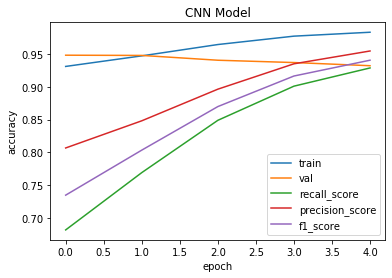

In [24]:
from matplotlib import pyplot as plt
print(history.history.keys())

# summarize result for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.plot(history.history['recall_score'])
plt.plot(history.history['precision_score'])
plt.plot(history.history['f1_score'])
plt.title('CNN Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val','recall_score', 'precision_score', 'f1_score'], loc='lower right')
plt.show()


In [25]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report,    accuracy_score, f1_score

print ('Accuracy:', accuracy_score(prediction.round(),y_test))
print ('F1 score:', f1_score( prediction.round(),y_test))
print ('Recall:', recall_score( prediction.round(),y_test))
print ('Precision:', precision_score( prediction.round(),y_test))
print ('\n clasification report:\n', classification_report(prediction.round(),y_test))



Accuracy: 0.9282456988875838
F1 score: 0.6488588334742181
Recall: 0.6912824207492796
Precision: 0.6113411914622491

 clasification report:
               precision    recall  f1-score   support

         0.0       0.97      0.95      0.96     26170
         1.0       0.61      0.69      0.65      2776

    accuracy                           0.93     28946
   macro avg       0.79      0.82      0.80     28946
weighted avg       0.93      0.93      0.93     28946

